In [1]:
import scenvi
import os
from scipy import sparse
from memory_profiler import memory_usage
import time


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="-1" # Change to -1 if you want to use CPU!

import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc
import colorcet
import sklearn.neighbors
import scipy.sparse
import umap.umap_ as umap
from fa2 import ForceAtlas2

In [3]:
def flatten(arr):
    return(np.reshape(arr, [arr.shape[0], -1]))

def force_directed_layout(affinity_matrix, cell_names=None, verbose=True, iterations=500, device='cpu'):
    """" Function to compute force directed layout from the affinity_matrix
    :param affinity_matrix: Sparse matrix representing affinities between cells
    :param cell_names: pandas Series object with cell names
    :param verbose: Verbosity for force directed layout computation
    :param iterations: Number of iterations used by ForceAtlas
    :return: Pandas data frame representing the force directed layout
    """

    init_coords = np.random.random((affinity_matrix.shape[0], 2))

    if device == 'cpu':
        forceatlas2 = ForceAtlas2(
            # Behavior alternatives
            outboundAttractionDistribution=False,
            linLogMode=False,
            adjustSizes=False,
            edgeWeightInfluence=1.0,
            # Performance
            jitterTolerance=1.0,
            barnesHutOptimize=True,
            barnesHutTheta=1.2,
            multiThreaded=False,
            # Tuning
            scalingRatio=2.0,
            strongGravityMode=False,
            gravity=1.0,
            # Log
            verbose=verbose)

        positions = forceatlas2.forceatlas2(
            affinity_matrix, pos=init_coords, iterations=iterations)
        positions = np.array(positions)


    positions = pd.DataFrame(positions,
                             index=np.arange(affinity_matrix.shape[0]), columns=['x', 'y'])
    return positions

def run_diffusion_maps(data_df, n_components=10, knn=30, alpha=0):
    """Run Diffusion maps using the adaptive anisotropic kernel
    :param data_df: PCA projections of the data or adjacency matrix
    :param n_components: Number of diffusion components
    :param knn: Number of nearest neighbors for graph construction
    :param alpha: Normalization parameter for the diffusion operator
    :return: Diffusion components, corresponding eigen values and the diffusion operator
    """

    # Determine the kernel
    N = data_df.shape[0]

    if(type(data_df).__module__ == np.__name__):
        data_df = pd.DataFrame(data_df)

    if not scipy.sparse.issparse(data_df):
        print("Determing nearest neighbor graph...")
        temp = sc.AnnData(data_df.values)
        sc.pp.neighbors(temp, n_pcs=0, n_neighbors=knn)
        kNN = temp.obsp['distances']

        # Adaptive k
        adaptive_k = int(np.floor(knn / 3))
        adaptive_std = np.zeros(N)

        for i in np.arange(len(adaptive_std)):
            adaptive_std[i] = np.sort(kNN.data[kNN.indptr[i] : kNN.indptr[i + 1]])[
                adaptive_k - 1
            ]

        # Kernel
        x, y, dists = scipy.sparse.find(kNN)

        # X, y specific stds
        dists = dists / adaptive_std[x]
        W = scipy.sparse.csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])

        # Diffusion components
        kernel = W + W.T
    else:
        kernel = data_df

    # Markov
    D = np.ravel(kernel.sum(axis=1))

    if alpha > 0:
        # L_alpha
        D[D != 0] = D[D != 0] ** (-alpha)
        mat = scipy.sparse.csr_matrix((D, (range(N), range(N))), shape=[N, N])
        kernel = mat.dot(kernel).dot(mat)
        D = np.ravel(kernel.sum(axis=1))

    D[D != 0] = 1 / D[D != 0]
    T = scipy.sparse.csr_matrix((D, (range(N), range(N))), shape=[N, N]).dot(kernel)
    # Eigen value dcomposition
    D, V = scipy.sparse.linalg.eigs(T, n_components, tol=1e-4, maxiter=1000)
    D = np.real(D)
    V = np.real(V)
    inds = np.argsort(D)[::-1]
    D = D[inds]
    V = V[:, inds]

    # Normalize
    for i in range(V.shape[1]):
        V[:, i] = V[:, i] / np.linalg.norm(V[:, i])

    # Create are results dictionary
    res = {"T": T, "EigenVectors": V, "EigenValues": D}
    res["EigenVectors"] = pd.DataFrame(res["EigenVectors"])
    if not scipy.sparse.issparse(data_df):
        res["EigenVectors"].index = data_df.index
    res["EigenValues"] = pd.Series(res["EigenValues"])
    res["kernel"] = kernel

    return res


def FDL(data, k = 30):


    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=int(k), metric='euclidean',
                               n_jobs=5).fit(data)
    kNN = nbrs.kneighbors_graph(data, mode='distance')
    # Adaptive k

    adaptive_k = int(np.floor(k / 3))
    nbrs = sklearn.neighbors.NearestNeighbors(n_neighbors=int(adaptive_k),
                           metric='euclidean', n_jobs=5).fit(data)
    adaptive_std = nbrs.kneighbors_graph(data, mode='distance').max(axis=1)
    adaptive_std = np.ravel(adaptive_std.todense())
    # Kernel
    x, y, dists = scipy.sparse.find(kNN)
    # X, y specific stds
    dists = dists / adaptive_std[x]
    N = data.shape[0]
    W = scipy.sparse.csr_matrix((np.exp(-dists), (x, y)), shape=[N, N])
    # Diffusion components
    kernel = W + W.T
    layout = force_directed_layout(kernel)
    return(layout)

In [4]:

start_time = time.time()  # Start time
memory_before = memory_usage()[0]  # Memory before execution

In [5]:
st_data = sc.read_h5ad('inputQuery/spatial_intestine.h5ad')
sc_data = sc.read_h5ad('inputRef/Original_counts.h5ad') #input_ref.h5ad
sc_data.obs['cell_type']=pd.Categorical(sc_data.obs['cluster'])
st_data.obs['cell_type']=pd.Categorical(st_data.obs['nico_ct'])


print(st_data)
print(sc_data)

print('1',st_data)
index=[]
for i in range(len(st_data.obs_names)):
    flag=1
    if st_data.obs['nico_ct'][i]=='NM':
        flag=0
    if st_data.obs['nico_ct'][i]=='Cycling/GC B cell':
        flag=1
    if st_data.obs['nico_ct'][i]=='pDC':
        flag=1
    if flag==1:
        index.append(i)

st_data=st_data[index]
print('2',st_data)


#sc.pp.highly_variable_genes(sc_data, flavor="seurat_v3", n_top_genes=3000)

AnnData object with n_obs × n_vars = 7416 × 241
    obs: 'x', 'y', 'cluster_id', 'nico_ct', 'cell_type'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2239 × 21197
    obs: 'cluster', 'n_counts', 'cell_type'
    var: 'n_cells'
    uns: 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
1 AnnData object with n_obs × n_vars = 7416 × 241
    obs: 'x', 'y', 'cluster_id', 'nico_ct', 'cell_type'
    obsm: 'spatial'
2 View of AnnData object with n_obs × n_vars = 7393 × 241
    obs: 'x', 'y', 'cluster_id', 'nico_ct', 'cell_type'
    obsm: 'spatial'


In [6]:
#print(st_data.X)
#print(sc_data.X)

In [7]:
'''
cell_type_palette = {'Astro': (0.843137, 0.0, 0.0, 1.0),
                     'Endo': (0.54902, 0.235294, 1.0, 1.0),
                     'L23_IT': (0.007843, 0.533333, 0.0, 1.0),
                     'L45_IT': (0.0, 0.67451, 0.780392, 1.0),
                     'L56_NP': (0.596078, 1.0, 0.0, 1.0),
                     'L5_ET': (1.0, 0.498039, 0.819608, 1.0),
                     'L5_IT': (0.423529, 0.0, 0.309804, 1.0),
                     'L5_PT': (1.0, 0.647059, 0.188235, 1.0),
                     'L6_CT': (0.345098, 0.231373, 0.0, 1.0),
                     'L6_IT': (0.0, 0.341176, 0.34902, 1.0),
                     'L6_IT_Car3': (0.0, 0.0, 0.866667, 1.0),
                     'L6b': (0.0, 0.992157, 0.811765, 1.0),
                     'Lamp5': (0.631373, 0.458824, 0.415686, 1.0),
                     'Microglia': (0.737255, 0.717647, 1.0, 1.0),
                     'OPC': (0.584314, 0.709804, 0.470588, 1.0),
                     'Oligo': (0.752941, 0.015686, 0.72549, 1.0),
                     'Pericytes': (0.392157, 0.329412, 0.454902, 1.0),
                     'Pvalb': (0.47451, 0.0, 0.0, 1.0),
                     'SMC': (0.027451, 0.454902, 0.847059, 1.0),
                     'Sncg': (0.996078, 0.960784, 0.564706, 1.0),
                     'Sst': (0.0, 0.294118, 0.0, 1.0),
                     'VLMC': (0.560784, 0.478431, 0.0, 1.0),
                     'Vip': (1.0, 0.447059, 0.4, 1.0)}

cell_label_palette = {'GABAergic': (0.843137, 0.0, 0.0, 1.0),
                      'Glutamatergic': (0.54902, 0.235294, 1.0, 1.0),
                      'Non-Neuronal': (0.007843, 0.533333, 0.0, 1.0)}
'''                      

"\ncell_type_palette = {'Astro': (0.843137, 0.0, 0.0, 1.0),\n                     'Endo': (0.54902, 0.235294, 1.0, 1.0),\n                     'L23_IT': (0.007843, 0.533333, 0.0, 1.0),\n                     'L45_IT': (0.0, 0.67451, 0.780392, 1.0),\n                     'L56_NP': (0.596078, 1.0, 0.0, 1.0),\n                     'L5_ET': (1.0, 0.498039, 0.819608, 1.0),\n                     'L5_IT': (0.423529, 0.0, 0.309804, 1.0),\n                     'L5_PT': (1.0, 0.647059, 0.188235, 1.0),\n                     'L6_CT': (0.345098, 0.231373, 0.0, 1.0),\n                     'L6_IT': (0.0, 0.341176, 0.34902, 1.0),\n                     'L6_IT_Car3': (0.0, 0.0, 0.866667, 1.0),\n                     'L6b': (0.0, 0.992157, 0.811765, 1.0),\n                     'Lamp5': (0.631373, 0.458824, 0.415686, 1.0),\n                     'Microglia': (0.737255, 0.717647, 1.0, 1.0),\n                     'OPC': (0.584314, 0.709804, 0.470588, 1.0),\n                     'Oligo': (0.752941, 0.015686, 0.

In [8]:
'''
plt.figure(figsize=(10,10))

sns.scatterplot(x = st_data.obsm['spatial'][st_data.obs['batch'] == 'mouse1_slice10'][:, 1],
                y = -st_data.obsm['spatial'][st_data.obs['batch'] == 'mouse1_slice10'][:, 0], legend = True,
                hue = st_data.obs['cell_type'][st_data.obs['batch'] == 'mouse1_slice10'],
                s = 12, palette = cell_type_palette)
plt.axis('equal')
plt.axis('off')
plt.title("MERFISH Data")
plt.show()
'''

'\nplt.figure(figsize=(10,10))\n\nsns.scatterplot(x = st_data.obsm[\'spatial\'][st_data.obs[\'batch\'] == \'mouse1_slice10\'][:, 1],\n                y = -st_data.obsm[\'spatial\'][st_data.obs[\'batch\'] == \'mouse1_slice10\'][:, 0], legend = True,\n                hue = st_data.obs[\'cell_type\'][st_data.obs[\'batch\'] == \'mouse1_slice10\'],\n                s = 12, palette = cell_type_palette)\nplt.axis(\'equal\')\nplt.axis(\'off\')\nplt.title("MERFISH Data")\nplt.show()\n'

In [9]:
sc_data.X.shape
sc.pp.highly_variable_genes(sc_data, flavor="seurat_v3", n_top_genes=3000)
sc_data.X=sc_data.X.todense()
type(sc_data.X)

numpy.matrix

In [10]:
fit = umap.UMAP(
    n_neighbors = 100,
    min_dist = 0.8,
    n_components = 2,
)

sc_data.layers['log'] = np.log(sc_data.X + 1)
#sc.pp.highly_variable_genes(sc_data, layer = 'log', n_top_genes = 2048)
sc_data.obsm['UMAP_exp'] = fit.fit_transform(np.log(sc_data[:, sc_data.var['highly_variable']].X + 1))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [11]:
'''
fig = plt.figure(figsize = (10,10))
sns.scatterplot(x = sc_data.obsm['UMAP_exp'][:, 0], y = sc_data.obsm['UMAP_exp'][:, 1],  hue = sc_data.obs['cell_type'], s = 16,
                palette = cell_type_palette, legend = True)
plt.tight_layout()
plt.axis('off')
plt.title('scRNA-seq Data')
plt.show()
'''

"\nfig = plt.figure(figsize = (10,10))\nsns.scatterplot(x = sc_data.obsm['UMAP_exp'][:, 0], y = sc_data.obsm['UMAP_exp'][:, 1],  hue = sc_data.obs['cell_type'], s = 16,\n                palette = cell_type_palette, legend = True)\nplt.tight_layout()\nplt.axis('off')\nplt.title('scRNA-seq Data')\nplt.show()\n"

In [12]:
# This function find the common gene index between two data.  
def find_index(sp_genename,sc_genename):
    index_sc=[]
    index_sp=[]
    d={}
    for j in range(len(sc_genename)):
        name=sc_genename[j]
        d[name]=j

    for i in range(len(sp_genename)):
        name=sp_genename[i]
        try:
            d[name]
            flag=1
        except KeyError:
            flag=0
        if flag==1:
            index_sc.append(d[name])
            index_sp.append(i)
    return index_sp,index_sc

In [13]:
sp_genename=st_data.var_names.to_numpy()
sc_genename=sc_data.var_names.to_numpy()

index_sp,index_sc=find_index(sp_genename,sc_genename)
ad_seq_common=sc_data[:,index_sc].copy()
st_data=st_data[:,index_sp].copy()

print(len(sp_genename[index_sp]))
print(len(sc_genename[index_sc]))

203
203


In [14]:
#type(ad_spatial_common.X)


In [15]:
envi_model = scenvi.ENVI(spatial_data = st_data, sc_data = sc_data)


Computing Niche Covariance Matrices
Initializing CVAE
Finished Initializing ENVI


In [16]:

envi_model.train() #training_steps=100
envi_model.impute_genes()
envi_model.infer_niche_covet()
envi_model.infer_niche_celltype()

 spatial: -2.623e-01 sc: -2.104e-01 cov: -4.014e-03 kl: 5.939e-01: 100%|█| 16000/16000 [1:34:47<00:00,  


Finished imputing missing gene for spatial data! See 'imputation' in obsm of ENVI.spatial_data


python(58623) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [17]:
st_data.obsm['envi_latent'] = envi_model.spatial_data.obsm['envi_latent']
st_data.obsm['COVET'] = envi_model.spatial_data.obsm['COVET']
st_data.obsm['COVET_SQRT'] = envi_model.spatial_data.obsm['COVET_SQRT']
st_data.uns['COVET_genes'] =  envi_model.CovGenes
st_data.obsm['imputation'] = envi_model.spatial_data.obsm['imputation']
st_data.obsm['cell_type_niche'] = envi_model.spatial_data.obsm['cell_type_niche']

sc_data.obsm['envi_latent'] = envi_model.sc_data.obsm['envi_latent']
sc_data.obsm['COVET'] = envi_model.sc_data.obsm['COVET']
sc_data.obsm['COVET_SQRT'] = envi_model.sc_data.obsm['COVET_SQRT']
sc_data.obsm['cell_type_niche'] = envi_model.sc_data.obsm['cell_type_niche']
sc_data.uns['COVET_genes'] =  envi_model.CovGenes

In [18]:
fit = umap.UMAP(
    n_neighbors = 100,
    min_dist = 0.3,
    n_components = 2,
)

latent_umap = fit.fit_transform(np.concatenate([st_data.obsm['envi_latent'], sc_data.obsm['envi_latent']], axis = 0))

st_data.obsm['latent_umap'] = latent_umap[:st_data.shape[0]]
sc_data.obsm['latent_umap'] = latent_umap[st_data.shape[0]:]

In [19]:
lim_arr = np.concatenate([st_data.obsm['latent_umap'], sc_data.obsm['latent_umap']], axis = 0)


delta = 1
pre = 0.1
xmin = np.percentile(lim_arr[:, 0], pre) - delta
xmax = np.percentile(lim_arr[:, 0], 100 - pre) + delta
ymin = np.percentile(lim_arr[:, 1], pre) - delta
ymax = np.percentile(lim_arr[:, 1], 100 - pre) + delta

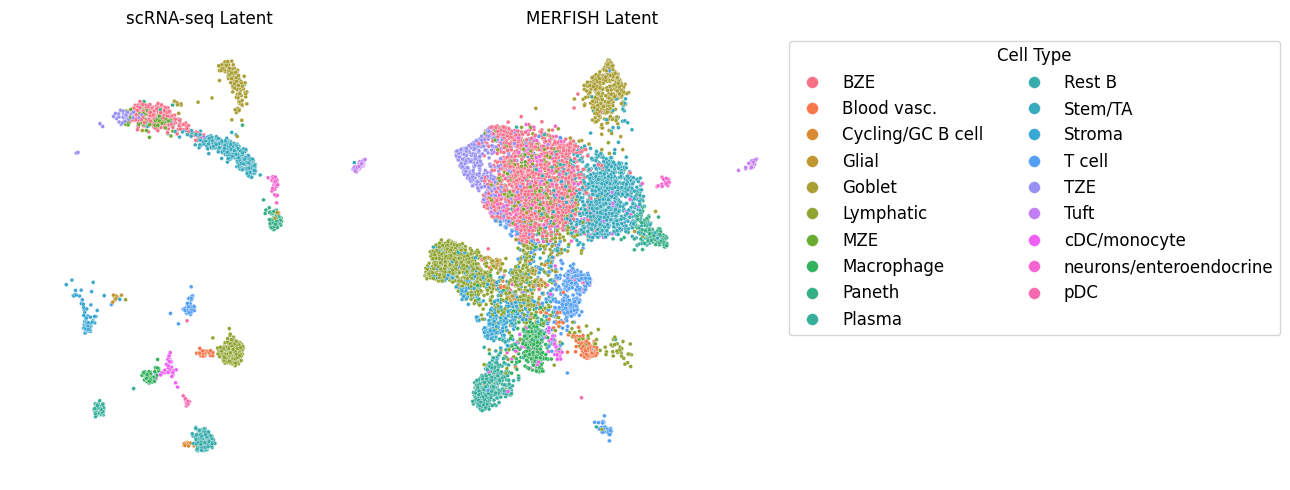

In [28]:

fig = plt.figure(figsize = (13,5))
plt.subplot(121)
sns.scatterplot(x = sc_data.obsm['latent_umap'][:, 0],
                y = sc_data.obsm['latent_umap'][:, 1], hue = sc_data.obs['cell_type'], s = 8,   legend = False) #palette = cell_type_palette,
plt.title("scRNA-seq Latent")
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.axis('off')

plt.subplot(122)
sns.scatterplot(x = st_data.obsm['latent_umap'][:, 0],
                y = st_data.obsm['latent_umap'][:, 1],  hue = st_data.obs['cell_type'], s = 8, legend = True) #palette = cell_type_palette


legend = plt.legend(title = 'Cell Type', prop={'size': 12}, fontsize = '12',  markerscale = 3, ncol = 2, bbox_to_anchor = (1, 1))#, loc = 'lower left')
plt.setp(legend.get_title(),fontsize='12')
plt.title("MERFISH Latent")
plt.axis('off')
plt.tight_layout()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()


In [21]:

end_time = time.time()  # End time
memory_after = memory_usage()[0]  # Memory after execution
execution_time = end_time - start_time  # Execution time
memory_used = memory_after - memory_before  # Memory used
print("execution_time, memory_used")
print(execution_time, memory_used)


execution_time, memory_used
5764.372478961945 3790.32421875


In [29]:
st_data_sst = st_data[st_data.obs['cell_type'] == 'Stem/TA']
sc_data_sst = sc_data[sc_data.obs['cell_type'] == 'Stem/TA']

In [23]:
sc_data

AnnData object with n_obs × n_vars = 2239 × 21197
    obs: 'cluster', 'n_counts', 'cell_type'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'neighbors', 'pca', 'umap', 'hvg', 'COVET_genes'
    obsm: 'X_pca', 'X_umap', 'UMAP_exp', 'envi_latent', 'COVET', 'COVET_SQRT', 'cell_type_niche', 'latent_umap'
    varm: 'PCs'
    layers: 'log'
    obsp: 'connectivities', 'distances'

In [24]:
sc_data.X=sparse.csr_matrix(sc_data.X)
sc_data.layers['log']=sparse.csr_matrix(sc_data.layers['log'])

In [25]:
st_data.write_h5ad('envi_output_ST.h5ad')
sc_data.write_h5ad('envi_output_SC.h5ad')

In [26]:
'''
gran_sst_palette = {'Th': (0.0, 0.294118, 0.0, 1.0),
                    'Calb2': (0.560784, 0.478431, 0.0, 1.0),
                    'Chodl': (1.0, 0.447059, 0.4, 1.0),
                    'Myh8': (0.933333, 0.72549, 0.72549, 1.0),
                    'Crhr2': (0.368627, 0.494118, 0.4, 1.0),
                    'Hpse': (0.65098, 0.482353, 0.72549, 1.0),
                    'Hspe': (0.352941, 0.0, 0.643137, 1.0),
                    'Crh': (0.607843, 0.894118, 1.0, 1.0),
                    'Pvalb Etv1': (0.92549, 0.0, 0.466667, 1.0)}
'''                    

"\ngran_sst_palette = {'Th': (0.0, 0.294118, 0.0, 1.0),\n                    'Calb2': (0.560784, 0.478431, 0.0, 1.0),\n                    'Chodl': (1.0, 0.447059, 0.4, 1.0),\n                    'Myh8': (0.933333, 0.72549, 0.72549, 1.0),\n                    'Crhr2': (0.368627, 0.494118, 0.4, 1.0),\n                    'Hpse': (0.65098, 0.482353, 0.72549, 1.0),\n                    'Hspe': (0.352941, 0.0, 0.643137, 1.0),\n                    'Crh': (0.607843, 0.894118, 1.0, 1.0),\n                    'Pvalb Etv1': (0.92549, 0.0, 0.466667, 1.0)}\n"

In [30]:

FDL_COVET = np.asarray(FDL(np.concatenate([flatten(st_data_sst.obsm['COVET_SQRT']),
                                           flatten(sc_data_sst.obsm['COVET_SQRT'])], axis = 0), k = 30))

st_data_sst.obsm['FDL_COVET'] = FDL_COVET[:st_data_sst.shape[0]]
sc_data_sst.obsm['FDL_COVET'] = FDL_COVET[st_data_sst.shape[0]:]

100%|█████████████████████████████████████████████████████████████████| 500/500 [01:32<00:00,  5.41it/s]


BarnesHut Approximation  took  8.69  seconds
Repulsion forces  took  68.51  seconds
Gravitational forces  took  0.42  seconds
Attraction forces  took  13.20  seconds
AdjustSpeedAndApplyForces step  took  1.21  seconds


In [31]:
DC_COVET = np.asarray(run_diffusion_maps(np.concatenate([flatten(st_data_sst.obsm['COVET_SQRT']),
                                                         flatten(sc_data_sst.obsm['COVET_SQRT'])], axis = 0), knn = 30)['EigenVectors'])[:, 1:]
st_data_sst.obsm['DC_COVET'] = -DC_COVET[:st_data_sst.shape[0]]
sc_data_sst.obsm['DC_COVET'] = -DC_COVET[st_data_sst.shape[0]:]

Determing nearest neighbor graph...


In [32]:
st_data_sst.obsm['DC_COVET'] = -DC_COVET[:st_data_sst.shape[0]]
sc_data_sst.obsm['DC_COVET'] = -DC_COVET[st_data_sst.shape[0]:]

In [33]:
lim_arr = np.concatenate([st_data_sst.obsm['FDL_COVET'], sc_data_sst.obsm['FDL_COVET']], axis = 0)


delta = 1000
pre = 0.01
xmin = np.percentile(lim_arr[:, 0], pre) - delta
xmax = np.percentile(lim_arr[:, 0], 100 - pre) + delta
ymin = np.percentile(lim_arr[:, 1], pre) - delta
ymax = np.percentile(lim_arr[:, 1], 100 - pre) + delta

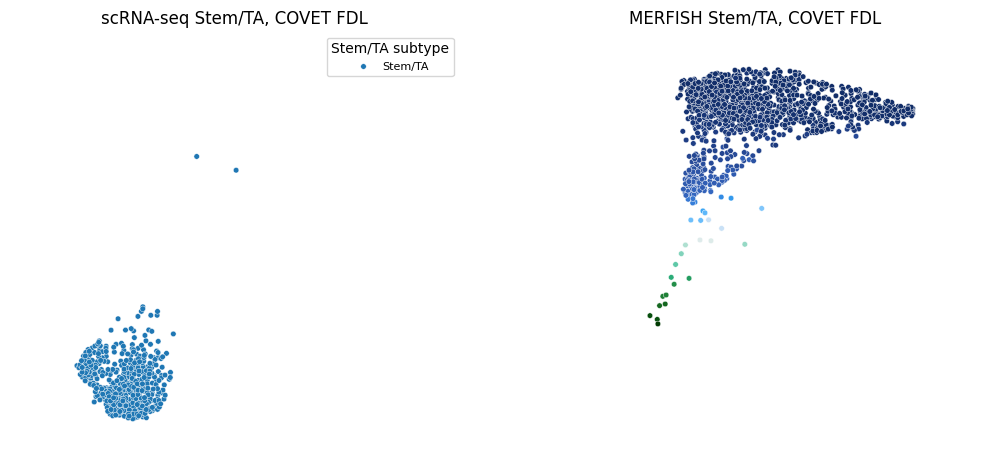

In [47]:

plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(x = sc_data_sst.obsm['FDL_COVET'][:, 0],
                y = sc_data_sst.obsm['FDL_COVET'][:, 1] , s = 16, hue = sc_data_sst.obs['cluster'],  legend = True)#palette= gran_sst_palette, 
plt.tight_layout()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.title('scRNA-seq Stem/TA, COVET FDL')
legend = plt.legend(title = 'Stem/TA subtype', prop={'size': 8}, fontsize = '8',  markerscale = 1, ncol = 2)
plt.axis('off')

plt.subplot(122)
ax = sns.scatterplot(x = st_data_sst.obsm['FDL_COVET'][:, 0],
                y = st_data_sst.obsm['FDL_COVET'][:, 1],
                c = st_data_sst.obsm['DC_COVET'][:,0], s = 16,  cmap= 'cet_CET_D13', legend = False)
plt.tight_layout()
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.axis('off')
plt.title('MERFISH Stem/TA, COVET FDL')
plt.show()

In [ ]:
'''
fig = plt.figure(figsize=(25,5))

for ind, batch in enumerate(['mouse1_slice212', 'mouse1_slice162', 'mouse1_slice71', 'mouse2_slice270', 'mouse1_slice40']):
    st_dataBatch = st_data[st_data.obs['batch'] == batch]
    st_dataPlotBatch = st_data_sst[st_data_sst.obs['batch'] == batch]

    plt.subplot(1,5, 1+ ind)
    sns.scatterplot(x = st_dataBatch.obsm['spatial'][:, 0], y = st_dataBatch.obsm['spatial'][:, 1],  color = (207/255,185/255,151/255, 1))
    sns.scatterplot(x = st_dataPlotBatch.obsm['spatial'][:, 0], y = st_dataPlotBatch.obsm['spatial'][:, 1], marker = '^',
                        c = st_dataPlotBatch.obsm['DC_COVET'][:, 0], s = 256,  cmap= 'cet_CET_D13', legend = False)
    plt.title(batch)
    plt.axis('off')
    plt.tight_layout()

plt.show()
'''

In [37]:
sc_data_sst

AnnData object with n_obs × n_vars = 420 × 21197
    obs: 'cluster', 'n_counts', 'cell_type'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'neighbors', 'pca', 'umap', 'hvg', 'COVET_genes'
    obsm: 'X_pca', 'X_umap', 'UMAP_exp', 'envi_latent', 'COVET', 'COVET_SQRT', 'cell_type_niche', 'latent_umap', 'FDL_COVET', 'DC_COVET'
    varm: 'PCs'
    layers: 'log'
    obsp: 'connectivities', 'distances'

In [39]:
depth_df = pd.DataFrame()
depth_df['Subtype'] = sc_data_sst.obs['cluster']
depth_df['Depth'] = -sc_data_sst.obsm['DC_COVET'][:,0]

In [40]:
subtype_depth_order = depth_df.groupby(['Subtype']).mean().sort_values(by = 'Depth', ascending=False).index


# Niche Cell Type Composition

In [42]:
subtype_canonical = pd.DataFrame([sc_data_sst[sc_data_sst.obs['cluster']==subtype].obsm['cell_type_niche'].mean(axis = 0) for subtype in subtype_depth_order],
                                     index = subtype_depth_order, columns = sc_data.obsm['cell_type_niche'].columns)

In [43]:
subtype_canonical[subtype_canonical<0.2] = 0
subtype_canonical.drop(labels=subtype_canonical.columns[(subtype_canonical == 0).all()], axis=1, inplace=True)
subtype_canonical = subtype_canonical.div(subtype_canonical.sum(axis=1), axis=0)

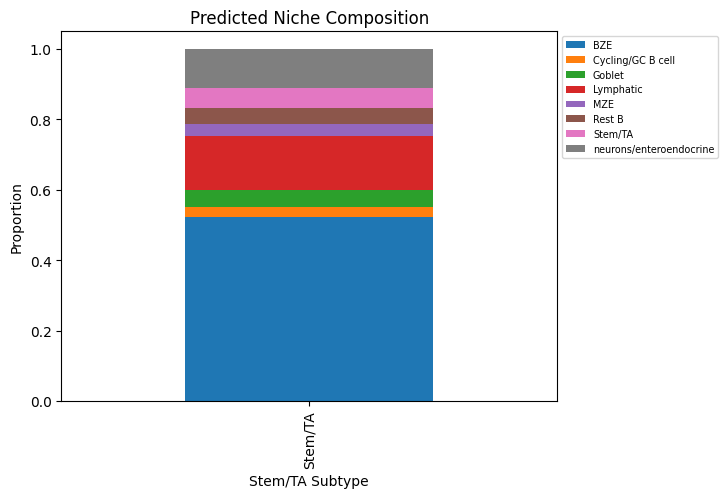

In [45]:
subtype_canonical.plot(kind = 'bar', stacked = 'True')
                       #color = {col:cell_type_palette[col] for col in subtype_canonical.columns})
plt.legend(bbox_to_anchor = (1,1), ncols = 1, fontsize = 'x-small')
plt.title("Predicted Niche Composition")
plt.ylabel("Proportion")
plt.xlabel("Stem/TA Subtype")
plt.show()